### Exploring interpretabilty of cancer dataset

In this code snippet, I have used the following libraries to understand how individual and collective features work in coalitions to define the target.

`shap`, `azureml`, `eli5`

There are another library e.g. skater which can be explored to understand the interpretability of the features for a target variable.

**Import Required library**

In [84]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
import shap
from interpret.ext.blackbox import TabularExplainer
from interpret_community.widget import ExplanationDashboard
shap.initjs()

####  Loading breast cancer dataset to see how model interpretability can be explained on a Random Forest
 
Class Distribution: 212 - Malignant(0), 357 - Benign(1)
 
The idea of this notebook is not making a good model but showing how existing state-of-art techniques can be used to understand the prediction in a better way. 

In [85]:
cancer_dataset = shap.datasets.sklearn.datasets.load_breast_cancer()
feature_names = cancer_dataset.feature_names
class_names = ["Malignant(0)", "Benign(1)"]
X_train, X_test, Y_train, Y_test = train_test_split(cancer_dataset.data, cancer_dataset.target, test_size=0.25, random_state=23)
rfc = RandomForestClassifier()
rfc.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

**Before using interpretable library, let's see which features are important for forest tree**

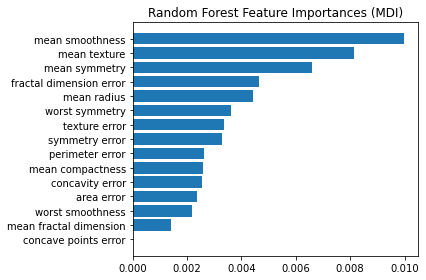

In [86]:
def plot_imp_features(model, top_n):
    try:
        tree_feature_importances = rfc.feature_importances_
    except Exception as e:
        raise TypeError(f"Model must be a type of DecisionTree to use feature_importances_ Excpetion is {e}")
    sorted_idx = tree_feature_importances.argsort()
    select_n = sorted_idx[:top_n]
    y_ticks = np.arange(0, len(select_n))
    fig, ax = plt.subplots()
    
    ax.barh(y_ticks, tree_feature_importances[select_n])
    ax.set_yticklabels(feature_names[select_n])
    ax.set_yticks(y_ticks)
    ax.set_title("Random Forest Feature Importances (MDI)")
    fig.tight_layout()
    plt.show()
    
plot_imp_features(rfc, 15)

In [87]:
print(classification_report(Y_test, rfc.predict(X_test), target_names=class_names))

              precision    recall  f1-score   support

Malignant(0)       0.94      0.96      0.95        48
   Benign(1)       0.98      0.97      0.97        95

 avg / total       0.97      0.97      0.97       143



## SHAP (SHapley Additive exPlanations)

Now let's use shap lib to see how we can explain the impact of feature on target class

In [92]:
# use TreeExplainer SHAP to explain test set predictions
explainer = shap.TreeExplainer(rfc, X_train, link="logit")
shap_values = explainer.shap_values(X_test, check_additivity=False) # with check_additivity code is broken. Please see the open issue in https://github.com/slundberg/shap/issues/950

**In below force_plot  two color codes are used to plot a relationship between the shap value and features.**

To grasp the idea of the plot we need to understand a few things.

<span style="color:#F3235F">Color red shows how a particular features push the prediction to baseline --->
    
<span style="color:blue"> Blue shows how a particular features pull the prediction from baseline <--- </span>
    
With the understanding of the color code, let us understand how the below features are explaining the outcome of the model.

Force plot shows the cumulative impact of various features and their values on the model output. In the below diagram the predicted value is 0.40; and `worst concavity `, `worst concavity `, `worst perimeter` is pushing the predictions from base value 0.6143 to 0.40 with hightest contribution point.
    
If we follow the red color code then we can see that other features are pushing total prediction towards right hand side i.e. 1(Benign).

In [96]:
# Let's see first 10 classes for X_test dataset
Y_test[:10], 

(array([1, 1, 0, 1, 0, 0, 0, 1, 1, 0]),)

In [97]:
expected_index = 1 # indexes are 1,0
test_data_index = 1 # test_data_index can range from 0 to len(test_data_index)
shap.force_plot(explainer.expected_value[expected_index], 
                shap_values[expected_index][test_data_index,:], 
                X_test[test_data_index,:],
                feature_names=feature_names)


With above understanding let's see the second data point and here we see all features e.g. `worst area `, `worst perimeter  `, `worst radius`, `worst concavity`, etc are pushing the prediction towards 0(malignant)

In [99]:
expected_index, test_data_index = 1, 2 # test_data_index can range from 0 to len(test_data_index)
shap.force_plot(explainer.expected_value[expected_index], 
                shap_values[expected_index][test_data_index, :], 
                X_test[test_data_index, :],
                feature_names=feature_names)

**If we take many explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally, we can see explanations for an entire dataset**

In [37]:
i=0 # class label. Can be change to 1 to see the behavior
shap.force_plot(explainer.expected_value[i], shap_values[i], features=X_test, feature_names=feature_names)

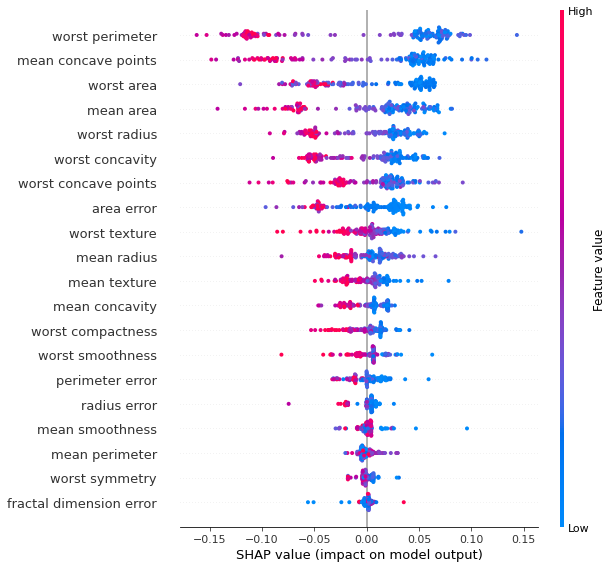

In [51]:
i=1
shap.summary_plot(shap_values[i], features=X_test, 
                  feature_names=feature_names, 
                  class_names=class_names)

 #### SHAP Dependence Plot represents the marginal effect one or two features have on the predicted outcome of a predictive model.
 
 *This plot draw the diagram by keeping feature on X axis and it's SHAP value in Y axis*
 
Lets understand single feature : The function automatically includes another variable that most interacts with choosen one. The below plot shows there is a negative trend between `mean texture` and the target variable, and `mean radius` interacts with `mean texture` frequently.

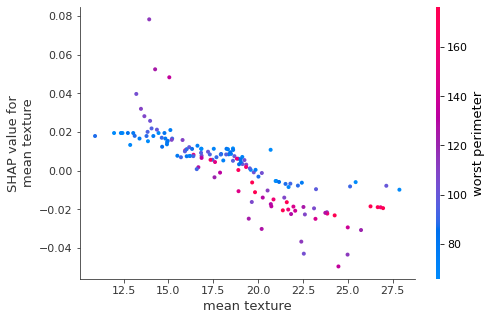

In [39]:
shap.dependence_plot(1, shap_values[1], features=X_test, feature_names=feature_names)

### The following code can be run to visualize the SHAP values for each class and features

In [25]:
# This piece of code can be used to visualize the SHAP values for each class and features
for feature_name in range(len(feature_names)):
    for target_label in range(len(cancer_dataset.target_names)):
        shap.dependence_plot(feature_name, shap_values[target_label], features=X_test, feature_names=feature_names)

<pr>In decision_plot we can see that all features are impacting either positevely or negatively. Color code explanation can be take into consideration while understanding the feature's impact towards or from base value</pr> 

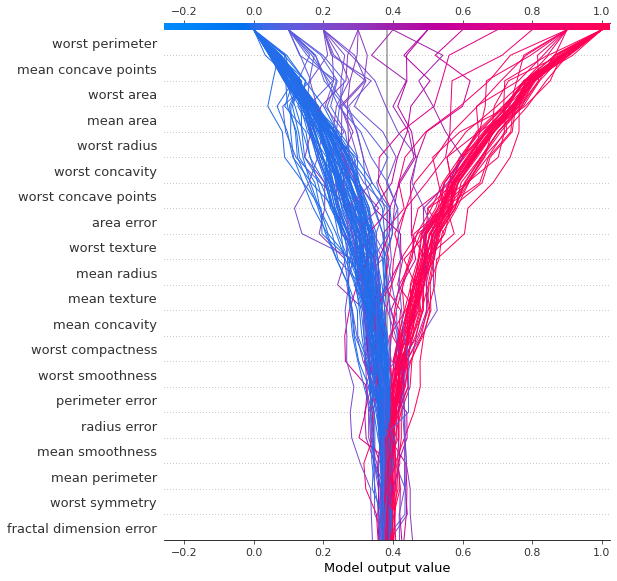

In [40]:
shap.decision_plot(explainer.expected_value[0], 
                   shap_values[0], 
                   features=X_test, 
                   feature_names=list(feature_names), 
                   return_objects=True)

**SHAP lib also contains other explainers like `PermutationExplainer`, `GradientExplainer`, `KernelExplainer`, `LinearExplainer`, `DeepExplainer` etc.**
In API we can check in details about these explainer

In [41]:
dir(shap)

['BruteForceExplainer',
 'DeepExplainer',
 'GradientExplainer',
 'KernelExplainer',
 'LinearExplainer',
 'PartitionExplainer',
 'PermutationExplainer',
 'SamplingExplainer',
 'Tree',
 'TreeExplainer',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_cext',
 'approximate_interactions',
 'bar_plot',
 'common',
 'datasets',
 'decision_plot',
 'dependence_plot',
 'embedding_plot',
 'explainers',
 'force_plot',
 'have_matplotlib',
 'hclust_ordering',
 'image_plot',
 'initjs',
 'kmeans',
 'matplotlib',
 'monitoring_plot',
 'multioutput_decision_plot',
 'other',
 'partial_dependence_plot',
 'plots',
 'sample',
 'save_html',
 'summary_plot',
 'unsupported',
 'warnings',
 'waterfall_plot']

### LIME (Local Interpretable Model-Agnostic Explanations)

In [105]:
cancer_dataset.target_names, class_names

(array(['malignant', 'benign'], dtype='<U9'), ['Malignant(0)', 'Benign(1)'])

In [111]:
from lime.lime_tabular import LimeTabularExplainer
np.random.seed(11)

In [170]:
tab_explainer =LimeTabularExplainer(X_train, feature_names=feature_names,
                                    class_names=class_names, 
                                    discretize_continuous=True,
                                    random_state=11)

In [171]:
list(class_names)

['Malignant(0)', 'Benign(1)']

In [172]:
def explain_model(model, test_data, index=0, num_features=1, top_labels=1): 
    if test_data.size ==0:
        raise ValueError("Empty dataset is passed")
    expl = tab_explainer.explain_instance(test_data[index], 
                                          model.predict_proba, 
                                          num_features=num_features, 
                                          top_labels=top_labels)
    
    expl.show_in_notebook(show_table=True,show_all=False)

In [195]:
cancer_dataset.feature_names[-7] # worst area
X_test[0][-7]

564.2

In [189]:
cancer_dataset.feature_names[-8] # worst perimeter
X_test[0][-8]

86.6

In [180]:
explain_model(rfc, X_test, index=0, num_features=10) # Y_test[1] = 1(Benign)

`In the above diagram we can see that worst area got value of 517.88 which less than its actual value i.e 86.6. We can check the the above value from the dataset`


In [196]:
cancer_dataset.feature_names[-7] # worst area
X_test[0][-7]

564.2

In [197]:
cancer_dataset.feature_names[-8] # worst perimeter
X_test[0][-8]

86.6

##### Let us check the explanation for 3rd rows of datset

In [199]:
explain_model(rfc, X_test, index=3, num_features=15) # Y_test[2] = 0 (malignant)

### AzureML

Azure has also published open source library under its azuleml SDK. The beautiful things about this library is that it can fit to any machine learning model which follows the priciple of scikit-learn methodology i.e. fit() and transform() 

If we are working with any custom algorithm then we can simply wrap our main model inside fit() and pass it to azureml to explain the features.

In [21]:
tab_explainer = TabularExplainer(rfc, X_train, features=feature_names, classes=[0, 1])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [22]:
global_explanation = tab_explainer.explain_global(X_test) # How globally all features set interpretate the outcome

In [23]:
global_feature_rank_values = dict(zip(global_explanation.get_ranked_global_names(),
                                      global_explanation.get_ranked_global_values()))
global_feature_rank_values

{'worst perimeter': 0.07595532987463141,
 'worst concave points': 0.06780037332226518,
 'worst radius': 0.06178580090500718,
 'worst area': 0.061688813644569004,
 'worst concavity': 0.051432037342211356,
 'mean area': 0.02544095929461229,
 'mean concavity': 0.022822935606762865,
 'mean perimeter': 0.02230714237151857,
 'mean concave points': 0.014994114385124891,
 'mean texture': 0.01426150261834639,
 'mean radius': 0.012523284263610842,
 'worst texture': 0.012036364340557092,
 'worst compactness': 0.011888211618859144,
 'worst smoothness': 0.007687756633585173,
 'mean compactness': 0.007227320108198555,
 'perimeter error': 0.006870732294207836,
 'area error': 0.006006945019138089,
 'worst symmetry': 0.0059455597100683925,
 'radius error': 0.00498892192057288,
 'compactness error': 0.00440812326792559,
 'mean fractal dimension': 0.004065060877333495,
 'concavity error': 0.003417519253002984,
 'texture error': 0.003318578728239531,
 'worst fractal dimension': 0.0029870047227208156,
 'sy

`ExplanationDashboard` is a powerful Dashboard Service which provides 4 basic plots tabs

**Data Exploration:** In this tab, we can choose the X and Y axis value to see the respective target distribution. On the right top corner, we can see the target class

**Global Importance:** Global importance variables and we can select `top K` features

**Explanation Exploration:** This tab, explain why a particular feature important for prediction.

**Summary Importance:** Summary of all features and their relationship with target variable.

In [24]:
ExplanationDashboard(global_explanation, rfc , datasetX=X_test)